[PCA] Running on 40 tiles with 1 processes...
Saved edge image to /O1.jpg
[PCA] Running on 40 tiles with 1 processes...
Saved edge image to /O1.jpg


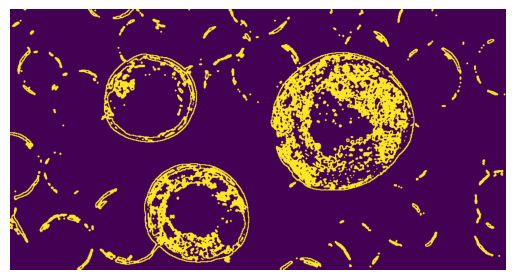

In [22]:
#!/usr/bin/env python3
"""
Parallel Cellular Automaton Edge Detection
- Uses multiprocessing to run CA updates on overlapping tiles.
- CA rule: if max absolute difference between center and neighbors > threshold -> edge
- Tweak: iterations, threshold, tile_size, overlap
Dependencies: numpy, opencv-python
Install: pip install numpy opencv-python
"""

import numpy as np
import cv2
import multiprocessing as mp
from functools import partial
import os
from typing import Tuple
import matplotlib.pyplot as plt

def pad_image(img: np.ndarray, pad: int) -> np.ndarray:
    return np.pad(img, pad_width=pad, mode='reflect')

def ca_step(tile: np.ndarray, threshold: int) -> np.ndarray:
    """
    Single CA step on the tile.
    tile: 2D uint8 grayscale tile (with overlap included)
    returns new tile (same shape), 0/255 values
    """
    # compute neighbors differences via convolution-like shifts
    center = tile
    # create array of max difference with neighbors
    maxdiff = np.zeros_like(tile, dtype=np.int16)

    # list of shifts (8 neighbors)
    shifts = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    for dy, dx in shifts:
        neigh = np.roll(np.roll(tile, dy, axis=0), dx, axis=1)
        diff = np.abs(center.astype(np.int16) - neigh.astype(np.int16))
        # update max difference
        maxdiff = np.maximum(maxdiff, diff)

    # rule: edge if maxdiff > threshold
    out = (maxdiff > threshold).astype(np.uint8) * 255
    return out

def run_ca_on_tile(tile_with_meta: Tuple[np.ndarray, int, int, int, int, int], iterations: int, threshold: int) -> Tuple[int,int,np.ndarray]:
    """
    tile_with_meta = (padded_tile, tile_y, tile_x, y0, x0, overlap)
    Returns (tile_y, tile_x, result_core_tile)
    """
    padded_tile, tile_y, tile_x, y0, x0, overlap = tile_with_meta
    tile = padded_tile.copy()
    for i in range(iterations):
        tile = ca_step(tile, threshold)
    # Extract core (remove overlap)
    if overlap > 0:
        core = tile[overlap:-overlap, overlap:-overlap].copy()
    else:
        core = tile
    return (tile_y, tile_x, core)

def split_image_to_tiles(img: np.ndarray, tile_size: int, overlap: int):
    """
    Splits image into tiles with padding (overlap) and returns list of tuples
    Each tuple: (padded_tile, tile_row_idx, tile_col_idx, y0, x0, overlap)
    """
    h, w = img.shape
    tiles = []
    rows = list(range(0, h, tile_size))
    cols = list(range(0, w, tile_size))

    pad = overlap
    padded_img = pad_image(img, pad)

    for i, y in enumerate(rows):
        for j, x in enumerate(cols):
            # coordinates in original image
            y0, x0 = y, x
            # tile region in padded image (include overlap on all sides)
            y1 = y0 + tile_size
            x1 = x0 + tile_size
            # but padded_img is shifted by pad
            py0 = y0
            px0 = x0
            # slice including overlap
            sy = py0
            sx = px0
            ey = py0 + tile_size + 2*pad
            ex = px0 + tile_size + 2*pad
            # handle edges: ensure we don't go out of padded bounds
            sy = max(0, sy)
            sx = max(0, sx)
            ey = min(padded_img.shape[0], ey)
            ex = min(padded_img.shape[1], ex)
            tile = padded_img[sy:ey, sx:ex].copy()
            # If tile is smaller at image boundaries, pad it back to expected shape
            expected_h = tile_size + 2*pad
            expected_w = tile_size + 2*pad
            if tile.shape[0] != expected_h or tile.shape[1] != expected_w:
                tile = pad_image(tile, 0)  # dummy
                tile = cv2.copyMakeBorder(tile, 0, expected_h - tile.shape[0],
                                          0, expected_w - tile.shape[1],
                                          borderType=cv2.BORDER_REFLECT)
            tiles.append((tile, i, j, y0, x0, pad))
    return tiles, rows, cols

def stitch_tiles(tiles_out, img_shape: Tuple[int,int], tile_size: int, overlap: int, rows, cols):
    h, w = img_shape
    out = np.zeros((h, w), dtype=np.uint8)
    for tile_y, tile_x, core in tiles_out:
        y = rows[tile_y]
        x = cols[tile_x]
        # determine actual area to write (important at edges)
        y1 = min(h, y + tile_size)
        x1 = min(w, x + tile_size)
        core_h = y1 - y
        core_w = x1 - x
        out[y:y1, x:x1] = core[:core_h, :core_w]
    return out

def parallel_pca_edge_detect(img_gray: np.ndarray, tile_size: int = 128,
                             overlap: int = 8, iterations: int = 2,
                             threshold: int = 20, processes: int = None) -> np.ndarray:
    """
    img_gray: 2D uint8 grayscale image
    tile_size: size of core tile (without overlap)
    overlap: number of pixels overlapped for neighbor context
    iterations: number of CA steps
    threshold: per-step threshold to decide edge
    processes: number of worker processes
    """
    if processes is None:
        processes = max(1, mp.cpu_count() - 1)

    tiles, rows, cols = split_image_to_tiles(img_gray, tile_size, overlap)
    print(f"[PCA] Running on {len(tiles)} tiles with {processes} processes...")

    # prepare args for pool
    tile_args = tiles

    with mp.Pool(processes=processes) as pool:
        fn = partial(run_ca_on_tile, iterations=iterations, threshold=threshold)
        results = pool.map(fn, tile_args)

    # results: list of (tile_y, tile_x, core)
    out = stitch_tiles(results, img_gray.shape, tile_size, overlap, rows, cols)
    return out

def main(input_path: str, output_path: str,
         tile_size: int=128, overlap: int=8, iterations: int=2, threshold: int=20):
    if not os.path.isfile(input_path):
        raise FileNotFoundError(f"Input not found: {input_path}")
    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Could not read input image (cv2 returned None)")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = parallel_pca_edge_detect(gray, tile_size=tile_size, overlap=overlap,
                                     iterations=iterations, threshold=threshold)
    # optional morphological cleanup (small)
    edges = cv2.medianBlur(edges, 3)
    cv2.imwrite(output_path, edges)
    print(f"Saved edge image to {output_path}")

# --- Direct call for Jupyter / Interactive run ---
input_path = "/1.jpg"           # put your image file here
output_path = "/O1.jpg"         # what you want to save as

# Optional tuning
tile_size = 128
overlap = 8
iterations = 2
threshold = 20

main(input_path, output_path, tile_size, overlap, iterations, threshold)
main(input_path, output_path, tile_size, overlap, iterations, threshold)
img = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.axis('off')
plt.show()